In [ ]:
#Group members - Akshata Mohan, Anurag Chilukuri, Daan Rozenbroek, Daniel Lindquist, Matt Staton, Valerie Roth

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import nltk
from nltk import word_tokenize
from collections import defaultdict
from collections import Counter
import operator
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from scipy.sparse import hstack
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
df = pd.read_csv("Train_rev1.csv")


PART A 

Q1 - What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?

In [3]:
#tokenization - we are using the regexp tokenizer because we do not want punctuations in our results. The regular exp represents a word so we take only words
df_1 = df.sample(10000, random_state=99)#taking a small subset of data cause doing it on the entire set takes a lot of time 
#print df_1
full_desc = df_1["FullDescription"]

token_list = []
for index,row in full_desc.iteritems():
    row = row.decode("utf-8")
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(row)
    for i in tokens:
        token_list.append(i)


In [4]:
lower_tokenlist = [t.lower() for t in token_list if t.isalpha()]

In [5]:
#pos tagging 
pos_tag = nltk.pos_tag(lower_tokenlist)
word_tag_fd = nltk.FreqDist(pos_tag)

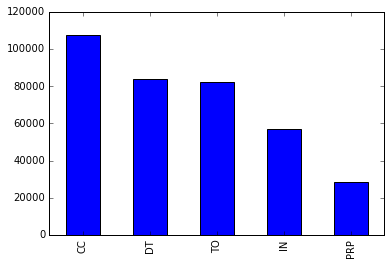

In [6]:
x = list(word_tag_fd)
y = Counter(word_tag_fd)
sorted_y = sorted(y.items(),key=operator.itemgetter(1), reverse = True)
pos_dict = {}
for i in range(len(sorted_y)):
    if sorted_y[i][0][1] in pos_dict.keys():
        continue
    else:
        pos_dict[sorted_y[i][0][1]] = sorted_y[i][1]
sorted_lst = sorted(pos_dict.items(), key = operator.itemgetter(1), reverse = True)
pos_series = pd.Series([x[1] for x in sorted_lst], [x[0] for x in sorted_lst])
pos_series.head(5).plot(kind = "bar")

Top 5 parts of speech : 
CC - coordinating conjunction [ 100000 ] 
TO - to [ 80000 ] 
DT - determiner [ 80000 ] 
IN - Preposition or subordinating conjunction [ 60000 ] 
PRP - personal pronoun [ 30000 ] 


Q2 - Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization.

In [7]:
count_word_freq = Counter(lower_tokenlist)

In [8]:
word_frequencies = []

most_common_100 = count_word_freq.most_common(100)
for i in range(len(most_common_100)):
    word_frequencies.append(most_common_100[i][1])

In [9]:
i = 1
word_frequencies_ideal = []
for i in range(len(word_frequencies)):
    word_frequencies_ideal.append((1.0)/(i+1))  

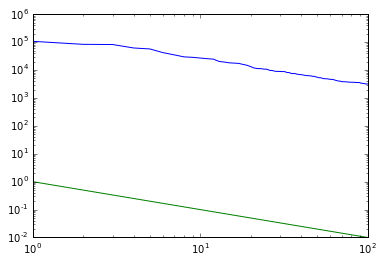

In [10]:
plt.plot([i for i in range(1, 1 + len(word_frequencies))], 
         [i for i in word_frequencies])

plt.plot([i for i in range(1, 1 + len(word_frequencies))], 
         [i for i in word_frequencies_ideal])
plt.xscale('log')
plt.yscale('log')


For words that are lower ranked ( very frequent words ) , the ziph's law does not seem to hold. For words that are higher ranked ( less frequent words ), ziphs law holds.  

Q3. If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What is their frequency?

In [11]:
clean_corpus = [word for word in lower_tokenlist if word not in stopwords.words('english')]


In [12]:
lemmatized = []
lemmatizer = WordNetLemmatizer()
for i in clean_corpus:
    lemmatized.append(lemmatizer.lemmatize(i))

In [13]:
count_word_freq_lemmatized = Counter(lemmatized)

In [14]:
count_word_freq_lemmatized.most_common(10)

[(u'experience', 17508),
 (u'role', 12732),
 (u'team', 12096),
 (u'client', 11837),
 (u'work', 11777),
 (u'business', 11235),
 (u'service', 9928),
 (u'skill', 9895),
 (u'working', 8939),
 (u'sale', 8931)]

PART B 

In [5]:
def classify_salary(s):
    if s >= percentile_train:
        return 1
    else:
        return 0
def classify_salary_test(s):
    if s >= percentile_test:
        return 1
    else:
        return 0

import random
df_train = df_1.sample(2000, random_state=99)
#df_train = df_1[1:500]
df_desc_train = df_train["FullDescription"].str.decode('utf-8')

salary = df_train["SalaryNormalized"]
salary_array = np.array(salary)

#train data salary classification
salary_train_sorted = sorted(salary)
percentile_train = salary_train_sorted[int(0.75 * len(salary_train_sorted))]
salary_labels = salary.map(classify_salary)
salary_labels = np.array(salary_labels)

#test data salary classification
df_test = df_1.sample(1000, random_state=99)
salary_test = df_test["SalaryNormalized"]
actual_sorted = sorted(salary_test)
percentile_test = actual_sorted[int(0.75 * len(actual_sorted))]
actual_labels = salary_test.map(classify_salary_test)

In [6]:
vectorizer = TfidfVectorizer(min_df=2, 
 ngram_range=(1, 1), 
 strip_accents='unicode', 
 norm='l2')
x_train = np.array([''.join(el) for el in df_desc_train])
train_transformed = vectorizer.fit_transform(x_train)


In [7]:
model_nb = MultinomialNB()
model_fit = model_nb.fit(train_transformed, salary_labels)


Confusion matrix, without normalization
[[738 248]
 [  0  14]]
0.752


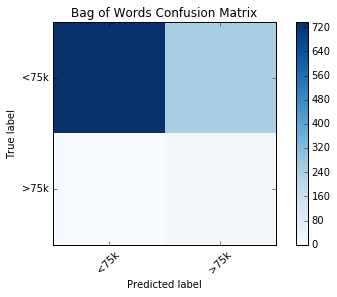

In [8]:
def classify_salary(s):
    if s >= percentile_prediction:
        return 1
    else:
        return 0

df_desc_test = df_test["FullDescription"].str.decode('utf-8')
x_test = np.array([''.join(el) for el in df_desc_test])
test_transformed = vectorizer.transform(x_test)
predictions = model_fit.predict(test_transformed)
predictions = pd.Series(predictions)
cm = confusion_matrix(predictions, actual_labels)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Bag of Words Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)  #Set to the number of classes 
    plt.xticks(tick_marks, ('<75k','>75k'), rotation=45)
    plt.yticks(tick_marks, ('<75k','>75k'))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)    
    
accuracy = (1.0 * cm[0][0]+cm[1][1])/ (sum(cm))
accuracy
print accuracy

B2 
Speculation - I think lemmatization would reduce the accuracy of the model. When you do lemmatization, you are basically reducing the word to it's root word. Even though you are considering the context into account, the final bag of words model contains just the frequency. You might incorrectly be adding to the frequency of a root word when it meant something else. Which in turn affects the accuracy.

In general with lemmatization you aren't just adding information, you are recategorizing words and thus there is a cost. Depending on the situation, the pos grouping of words by their lemmas may or may not lead to a better result. Basically the tradeoff is do the lemmas of words have more predictive power than other forms of the words.


With a small sample of only 500 lines, the lemmatization slightly worsened the model from .78 accuracy to .75. Either result would not have been surprising because we understand the inherent tradeoffs.

In [9]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
    


In [10]:
lemma_vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode', norm='l2', tokenizer=LemmaTokenizer())

In [11]:
train_lemma_transformed = lemma_vectorizer.fit_transform(df_desc_train)
test_lemma_transformed = lemma_vectorizer.transform(df_desc_test)

In [12]:
model_fit = model_nb.fit(train_lemma_transformed, salary_labels)


In [13]:
predictions_lemma = model_fit.predict(test_lemma_transformed)

0.738
Confusion matrix, without normalization
[[738 262]
 [  0   0]]


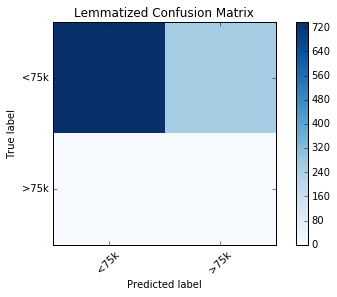

In [14]:
cm_lemma = confusion_matrix(predictions_lemma,actual_labels)
accuracy_lemma = ( 1.0 * cm_lemma[0][0] + cm_lemma[1][1])/sum(cm_lemma) 
print accuracy_lemma

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Lemmatized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)  #Set to the number of classes 
    plt.xticks(tick_marks, ('<75k','>75k'), rotation=45)
    plt.yticks(tick_marks, ('<75k','>75k'))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm_lemma)
plt.figure()
plot_confusion_matrix(cm_lemma)    

B3 : 
I think removing stopwords wouldn't affect accuracy of the model much because stop words are equally distibuted in both the classes and not contribute much information to the model ( noise ). Removing it would increase the interpretability of the model.


In [15]:
stop_vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode',\
                norm='l2', stop_words='english')

train_nostop_transformed = stop_vectorizer.fit_transform(df_desc_train)
test_nostop_transformed = stop_vectorizer.transform(df_desc_test)

In [16]:
model_fit = model_nb.fit(train_nostop_transformed, salary_labels)
predictions_stop_words = model_fit.predict(test_nostop_transformed)

0.741
Confusion matrix, without normalization
[[738 259]
 [  0   3]]


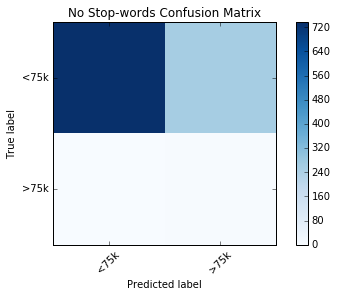

In [17]:
cm_stop_words = confusion_matrix(predictions_stop_words,actual_labels)
accuracy_stop_words = ( 1.0 * cm_stop_words[0][0] + cm_stop_words[1][1])/sum(cm_stop_words) 
print accuracy_stop_words

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('No Stop-words Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)  #Set to the number of classes 
    plt.xticks(tick_marks, ('<75k','>75k'), rotation=45)
    plt.yticks(tick_marks, ('<75k','>75k'))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm_stop_words)
plt.figure()
plot_confusion_matrix(cm_stop_words)  

top 10 words for high salary

In [18]:
no_stop_words = df_train["FullDescription"]

mask = salary_labels == 1
top_10_desc = no_stop_words[mask]

word_list = []
for index,row in top_10_desc.iteritems():
    row = row.decode("utf-8")
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(row)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    filtered_words = [word for word in tokens if word not in stopwords.words('english')]
    for i in filtered_words:
        word_list.append(i)



In [19]:
top_10 = Counter(word_list)
top_10.most_common(10)

[(u'experience', 1031),
 (u'business', 774),
 (u'role', 638),
 (u'management', 594),
 (u'team', 572),
 (u'work', 546),
 (u'skills', 496),
 (u'within', 468),
 (u'project', 449),
 (u'development', 443)]

top 10 words for low salary

In [20]:
no_stop_words = df_train["FullDescription"]

mask = salary_labels == 0
top_10_desc = no_stop_words[mask]

word_list = []
for index,row in top_10_desc.iteritems():
    row = row.decode("utf-8")
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(row)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    filtered_words = [word for word in tokens if word not in stopwords.words('english')]
    for i in filtered_words:
        word_list.append(i)

In [21]:
top_10 = Counter(word_list)
top_10.most_common(10)

[(u'experience', 2465),
 (u'role', 1754),
 (u'work', 1697),
 (u'team', 1606),
 (u'skills', 1422),
 (u'sales', 1418),
 (u'working', 1393),
 (u'business', 1357),
 (u'within', 1267),
 (u'client', 1184)]

B4: 

In [22]:
class pos_tag_bigram(object):
    def __init__(self):
        pass
    def __call__(self, doc):
        return nltk.Text(nltk.bigrams([i[1] for i in nltk.pos_tag(nltk.word_tokenize(doc))]))
    
    
    

In [23]:
bigram_pos_vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode',tokenizer=pos_tag_bigram())

train_pos_bigram_transformed = bigram_pos_vectorizer.fit_transform(df_desc_train)
test_pos_bigram_transformed = bigram_pos_vectorizer.transform(df_desc_test)

In [25]:
model_fit = model_nb.fit(train_pos_bigram_transformed, salary_labels)
predictions_pos_bigram = model_fit.predict(test_pos_bigram_transformed)

In [26]:
cm_pos_bigram = confusion_matrix(predictions_pos_bigram,actual_labels)
accuracy_pos_bigram = ( 1.0 * cm_pos_bigram[0][0] + cm_pos_bigram[1][1])/sum(cm_pos_bigram) 
accuracy_pos_bigram

0.738

No, the accuracy does not seem to increase over b1. In fact, it remains about the same. 